In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [72]:
df = pd.read_csv("../dataset/logistics_clean.csv")
df.head()

,Shipment_ID,Origin_Warehouse,Destination,Carrier,Shipment_Date,Delivery_Date,Weight_kg,Cost,Status,Distance_miles,Transit_Days
0,SH10000,Warehouse_MIA,San Francisco,UPS,2023-10-02,2023-10-04,25.7,67.46,Delivered,291,2
1,SH10001,Warehouse_MIA,Atlanta,DHL,2023-12-06,2023-12-09,38.9,268.85,Delivered,1225,3
2,SH10002,Warehouse_LA,Houston,DHL,2023-09-18,2023-09-20,37.2,74.35,Delivered,220,2
3,SH10003,Warehouse_BOS,Seattle,OnTrac,2023-01-26,2023-02-04,42.6,187.04,Delivered,1156,9
4,SH10004,Warehouse_SF,Dallas,OnTrac,2023-06-03,2023-06-06,7.9,120.01,Delivered,1017,3


In [73]:
df['Status'].value_counts()

Status
Delivered     1481
In Transit      72
Lost            40
Returned        29
Delayed         18
Name: count, dtype: int64

In [74]:
X = df[['Origin_Warehouse', 'Destination', 'Carrier', 'Shipment_Date',
        'Weight_kg', 'Distance_miles']]
y = df['Cost']

In [75]:
# Ekstrak hari dari tanggal pengiriman (feature engineering ringan)
X['Shipment_Date'] = pd.to_datetime(X['Shipment_Date'])
X['Ship_DayOfWeek'] = X['Shipment_Date'].dt.day_name()
X = X.drop(columns=['Shipment_Date'])

C:\Users\User\AppData\Local\Temp\ipykernel_15924\277159098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Shipment_Date'] = pd.to_datetime(X['Shipment_Date'])
C:\Users\User\AppData\Local\Temp\ipykernel_15924\277159098.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Ship_DayOfWeek'] = X['Shipment_Date'].dt.day_name()


In [76]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [77]:
num_features = ['Weight_kg', 'Distance_miles']
cat_features = ['Origin_Warehouse', 'Destination', 'Carrier', 'Ship_DayOfWeek']

In [78]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

In [79]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
}


🚀 Training Linear Regression...


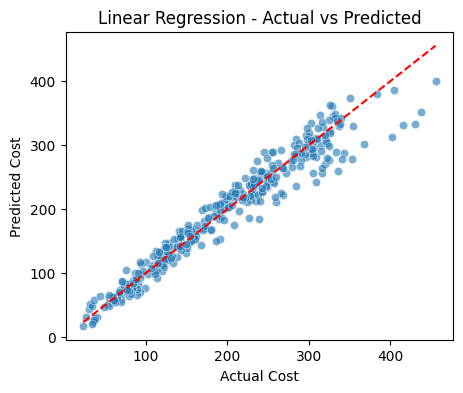


🚀 Training Random Forest...


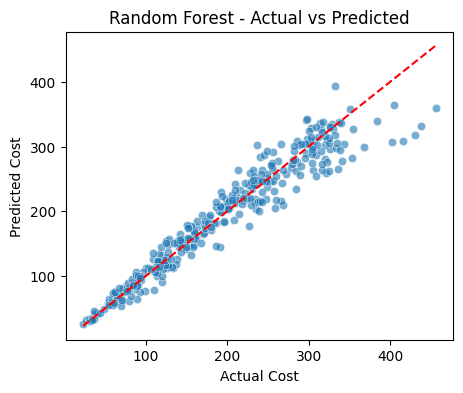


🚀 Training XGBoost...


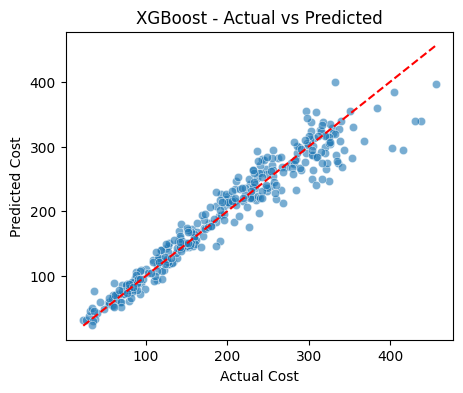

In [80]:
results = []

for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })
    
    # Visualisasi Prediksi vs Aktual
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.xlabel('Actual Cost')
    plt.ylabel('Predicted Cost')
    plt.title(f'{name} - Actual vs Predicted')
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             color='red', linestyle='--')
    plt.show()


In [81]:
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("\n=== Model Performance Comparison ===")
print(results_df)


=== Model Performance Comparison ===
               Model         MSE       RMSE        R²
0  Linear Regression  485.577988  22.035834  0.946107
2            XGBoost  619.207758  24.883886  0.931275
1      Random Forest  624.932989  24.998660  0.930640


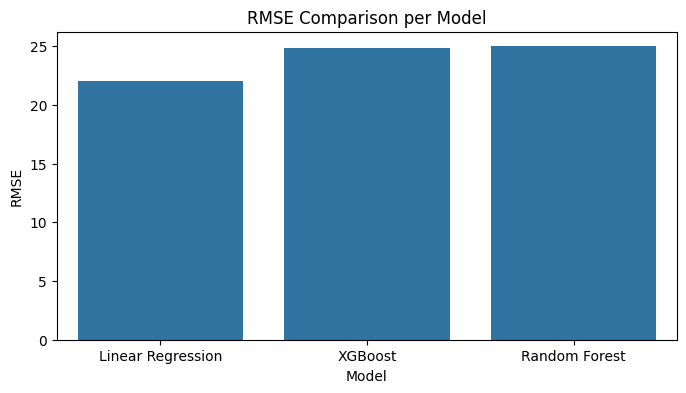

In [82]:
plt.figure(figsize=(8,4))
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title("RMSE Comparison per Model")
plt.show()

In [83]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

search_results = {}

# ===== Parameter grid =====
param_grids = {
    "Random Forest": {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__max_features': ['sqrt']
    },
    "XGBoost": {
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0],
        'model__n_estimators': [100, 300]
    }
}

# ===== Model dictionary =====
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# ===== Loop tuning =====
for name, model in models.items():
    print(f"\n🚀 Tuning {name}...")
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_grids[name],
        n_iter=15,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    search.fit(X_train, y_train)
    search_results[name] = search   
    
    print(f"✅ Best {name} params:", search.best_params_)
    print(f"🏁 Best {name} R² (CV mean): {search.best_score_:.4f}")

# Setelah ini, kamu bisa ambil best model:
# best_model = search.best_estimator_
# y_pred = best_model.predict(X_test)



🚀 Tuning Random Forest...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
✅ Best Random Forest params: {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 20}
🏁 Best Random Forest R² (CV mean): 0.8379

🚀 Tuning XGBoost...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
✅ Best XGBoost params: {'model__subsample': 0.8, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}
🏁 Best XGBoost R² (CV mean): 0.9126



=== Final XGBoost Tuned Performance on Test Set ===
MSE  : 545.9827
RMSE : 23.3663
R²   : 0.9394


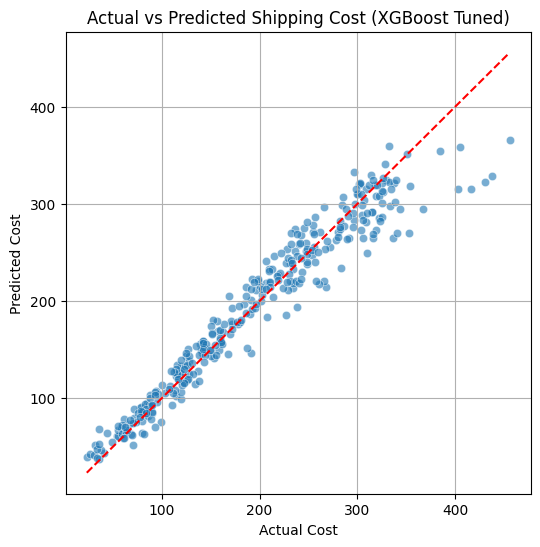

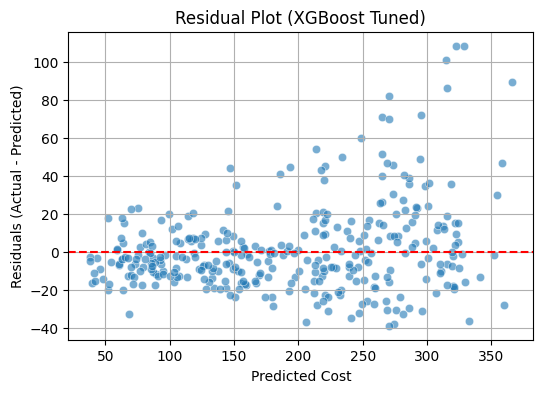

In [84]:
# --- Simpan model terbaik dari XGBoost ---
best_xgb_pipe = search_results["XGBoost"].best_estimator_

# --- Evaluasi di test set ---
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred = best_xgb_pipe.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== Final XGBoost Tuned Performance on Test Set ===")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# --- Visualisasi Prediksi vs Aktual ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.title("Actual vs Predicted Shipping Cost (XGBoost Tuned)")
plt.xlabel("Actual Cost")
plt.ylabel("Predicted Cost")
plt.grid(True)
plt.show()

# --- Residual Plot ---
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (XGBoost Tuned)")
plt.xlabel("Predicted Cost")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()


In [ ]:
# import joblib

# # Simpan pipeline terbaik
# joblib.dump(best_xgb_pipe, "../model/shipping_cost_xgb_tuned.pkl")
# print("✅ Model saved as 'shipping_cost_xgb_tuned.pkl'")


In [ ]:

# cols = ["Origin_Warehouse", "Destination", "Distance_miles"]
# df_lookup = df[cols].drop_duplicates().reset_index(drop=True)

# # Simpan ke file CSV untuk digunakan di Streamlit
# df_lookup.to_csv("../Logistics_ML/dataset/warehouse_distance_lookup.csv", index=False)

# print("✅ File lookup 'warehouse_distance_lookup.csv' berhasil dibuat.")
# print(df_lookup.head())
